In [69]:
import pandas as pd
import numpy as np
import datetime
import json
import re
import matplotlib.pyplot as plt

In [70]:
def convert_price(str_price):
    if type(str_price) != str:
        return str_price
    if ('－' in str_price) | ('なし' in str_price):
        return 0.0
    pos_price = str_price.find('円')
    str_price = str_price[0:pos_price+1]
    if '万円' in str_price:
        return float(str_price.replace('万円', '').replace(',', ''))*10000
    else:
        return float(str_price.replace('円', '').replace(',', ''))
    
    
def convert_area(str_area):
    if type(str_area) != str:
        return str_area
    if ('－' in str_area) | ('なし' in str_area):
        return 0.0
    elif ',' in str_area:
        #これは異常値なのでNaNを返す
        return np.nan
    else:
        return float(str_area.replace('m²', '').replace('（壁芯）','').replace('（内法）', ''))
    
def convert_age(str_age):
    if type(str_age) != str:
        return str_age
    pos_y = str_age.find('年')
    year = int(str_age[0:pos_y])
    pos_m = str_age.find('月')
    month = int(str_age[pos_y+1:pos_m])
    
    return (datetime.date.today().year - year)*12 + datetime.date.today().month - month

def convert_tosu(str_tosu):
    if type(str_tosu) != str:
        return str_tosu
    if str_tosu == '－':
        #これは欠損値なのでとりあえずNaNを返す
        return np.nan
    return int(str_tosu.replace('戸', '').replace(',', ''))

def convert_floor(str_floor):
    if type(str_floor) != str:
        return str_floor
    if str_floor == '－':
        # これは欠損値
        return np.nan
    pos_floor = str_floor.find('階')
    # 地下室は負の値にする
    return int(str_floor[0:pos_floor].replace('メゾネット', '').replace('地下','-'))
    

def convert_total_floor(str_floor):
    if type(str_floor) != str:
        return str_floor
    if str_floor == '－':
        # これは欠損値
        return np.nan
    pos_total_floor = str_floor.find('階')
    return int(str_floor[0:pos_total_floor].replace('地上', ''))

def convert_madori(str_madori):
    if str_madori == '－':
        return np.nan
    pos_madori = str_madori.find('(')
    if pos_madori > 0:
        str_madori = str_madori[0:pos_madori]
    
    rank = 0
    if str_madori == 'ワンルーム':
        rank = 16
    else:
        str_madori = str_madori.replace('１', '1')
        str_madori = str_madori.replace('２', '2')
        str_madori = str_madori.replace('３', '3')
        str_madori = str_madori.replace('４', '4')
        str_madori = str_madori.replace('５', '5')
        str_madori = str_madori.replace('６', '6')
        str_madori = str_madori.replace('７', '7')
        str_madori = str_madori.replace('８', '8')
        str_madori = str_madori.replace('９', '9')
        lists=re.findall(r'([0-9]*)',str_madori)
        rank = int(lists[0])*16
        if 'Ｓ' in str_madori:
            rank += 1
        if 'Ｋ' in str_madori:
            rank += 2
        if 'Ｄ' in str_madori:
            rank += 4
        if 'Ｌ' in str_madori:
            rank += 8
    return rank

def convert_parking(str_parking):
    if type(str_parking) != str:
        return str_parking
    pos = str_parking.find('有')
    if pos >= 0:
        return 1
    else:
        return 0

def convert_eki(str_koutu):
    if type(str_koutu) != str:
        return str_koutu
    pos = str_koutu.find('/')
    str_eki = str_koutu[pos+1:].strip()
    return str_eki
    
def convert_toho(str_koutu):
    if type(str_koutu) != str:
        return str_koutu
    pos_toho = str_koutu.find('徒歩')
    if pos_toho < 0:
        return np.nan
    pos_hun = str_koutu.find('分')
    str_hun = str_koutu[pos_toho+2:pos_hun].replace(' ','')
    try:
        hun = int(str_hun)
        return hun
    except:
        print(str_koutu)
        return 0
    
def convert_moyorieki(str_time):
    if type(str_time) != str:
        return str_time
    pos = str_time.find('分')
    return int(str_time[:pos])

In [92]:
today = '2018-6-16'

In [93]:
df_data_ori = pd.read_csv('./data/bunjou_' + today + '.csv')

In [94]:
#建物構造はSRCかRCまたはSRCとRCの混合が全てで、木造の物件がなかったため除外
delete_column = ['タイトル', 'その他交通', '所在地', '物件種目', '平米単価', '借地期間・地代（月額）', '権利金', '敷金 / 保証金', '維持費等',
                'その他一時金', '不要', '建物名・部屋番号', '建物状況調査　/　瑕疵保険・保証', '備考', '建物構造','リフォーム履歴', 'リノベーション履歴', 'バイク置き場',
                 '駐輪場', 'ペット', '敷地面積', '管理形態・方式', '国土法届出', '条件等', '現況', '引渡し', '物件番号',
                 '情報公開日', '次回更新予定日']
delete_column2 = ['タイトル', 'その他交通', '所在地', '物件種目', '平米単価', '借地期間・地代（月額）', '権利金', '敷金 / 保証金', '維持費等',
                'その他一時金', '不要', '建物名・部屋番号', '建物状況調査　/　瑕疵保険・保証', '備考', '建物構造','リフォーム履歴', 'リノベーション履歴', 'バイク置き場',
                 '駐輪場', 'ペット', '敷地面積', '管理形態・方式', '国土法届出', '条件等', '現況', '引渡し', '物件番号',
                 '情報公開日', '次回更新予定日']

In [95]:
df_data_ori.columns

Index(['タイトル', '交通', 'その他交通', '所在地', '物件種目', '価格', '平米単価', '管理費等', '修繕積立金',
       '借地期間・地代（月額）', '権利金', '敷金 / 保証金', '維持費等', 'その他一時金', '不要', '建物名・部屋番号',
       '設備', '建物状況調査　/　瑕疵保険・保証', '備考', '間取り', '専有面積', 'バルコニー', '階建 / 階',
       '建物構造', '築年月', '総戸数', 'リフォーム履歴', 'リノベーション履歴', '駐車場', 'バイク置き場', '駐輪場',
       'ペット', '土地権利', '敷地面積', '管理形態・方式', '国土法届出', '条件等', '現況', '引渡し', '物件番号',
       '情報公開日', '次回更新予定日'],
      dtype='object')

In [96]:
df_kari = df_data_ori
df_kari = df_kari.drop(delete_column2, axis=1)

In [97]:
price_column = ['価格', '管理費等', '修繕積立金']
area_column = ['専有面積', 'バルコニー']
for key in price_column:
    df_kari[key] = df_kari[key].map(convert_price)
for key in area_column:
    df_kari[key] = df_kari[key].map(convert_area)
    
df_kari['築年月'] = df_kari['築年月'].map(convert_age)
df_kari['総戸数'] = df_kari['総戸数'].map(convert_tosu)
df_kari['間取り'] = df_kari['間取り'].map(convert_madori)
df_kari['駐車場'] = df_kari['駐車場'].map(convert_parking)

df_floor = df_kari['階建 / 階'].str.split(' /', expand=True)
df_floor.columns = ['総階数', '階']
df_floor['総階数'] = df_floor['総階数'].map(convert_total_floor)
df_floor['階'] = df_floor['階'].map(convert_floor)
df_kari = pd.concat([df_kari, df_floor], axis=1)
df_kari = df_kari.drop('階建 / 階', axis=1)

df_transit = df_kari['交通'].str.split('駅', expand=True)
df_transit.columns = ['最寄り駅','駅から']
df_transit['最寄り駅'] = df_transit['最寄り駅'].map(convert_eki)
df_transit['駅から'] = df_transit['駅から'].map(convert_toho)
df_kari = pd.concat([df_kari, df_transit], axis=1)
df_kari = df_kari.drop('交通', axis=1)

df_kari.to_csv('list_eki.csv', columns=['最寄り駅'], index=False, header=False)

In [98]:
f = open('time_FromShinjuku.json', 'r', encoding='utf-8')
timeFromShinjuku_dict = json.load(f)
df_kari['最寄り駅'] = df_kari['最寄り駅'].map(timeFromShinjuku_dict)
df_kari['最寄り駅'] = df_kari['最寄り駅'].map(convert_moyorieki)

In [99]:
opts = {}
for i in range(0, len(df_kari['設備'])):
    #if df_kari['設備'][i]:
    setubi = df_kari['設備'][i].split("、")
    for j in range(0, len(setubi)):
        if setubi[j] in opts:
            opts[setubi[j]] += 1
        else:
            opts[setubi[j]] = 1
            
pd.DataFrame.from_dict(opts, orient='index').sort_values(by=0, ascending=False) 

,0
エレベーター,2841
システムキッチン,2381
都市ガス,2305
浴室乾燥機,2195
追焚機能,2092
オートロック,1989
モニター付インターホン,1922
室内洗濯機置場,1906
温水洗浄便座,1845
収納スペース,1747


In [100]:
opts_columns = {'浴室乾燥機': [], '温水洗浄便座': [], '追焚機能': [], 'オートロック': [], '宅配ＢＯＸ': [], '食器洗浄乾燥機': [], '床暖房': []}
for key in opts_columns:
    for i in range(0, len(df_kari)):
        opts_columns[key].append(1 if key in df_kari['設備'][i] else 0)
        
df_setubi = pd.DataFrame(opts_columns)
df_kari = pd.concat([df_kari, df_setubi], axis=1)
df_kari = df_kari.drop('設備', axis=1)

In [101]:
abnormal_data = []    
for i in range(0, len(df_kari.index)):
    for key in df_kari.columns:
        if pd.isnull(df_kari[key][i]):
            abnormal_data.append(i)
#print(abnormal_data)
#df_kari = df_kari.drop(abnormal_data, axis=0).reset_index(drop=True)
df_kari = df_kari.dropna(how='any').reset_index(drop='true')
df_kari = df_kari.drop_duplicates()

In [102]:
df_kari.to_csv('bunjou_cleaned_' + today + '.csv', index=True)

In [103]:
df_kari

,価格,管理費等,修繕積立金,間取り,専有面積,バルコニー,築年月,総戸数,駐車場,土地権利,...,階,最寄り駅,駅から,浴室乾燥機,温水洗浄便座,追焚機能,オートロック,宅配ＢＯＸ,食器洗浄乾燥機,床暖房
0,19800000.0,11500.0,13400.0,47,68.87,6.30,587,41.0,0,旧法賃借権,...,5.0,34.0,4.0,0,0,0,0,0,0,0
1,19800000.0,9411.0,14925.0,46,66.22,16.50,563,148.0,0,旧法賃借権,...,9.0,10.0,6.0,0,0,0,0,0,0,0
2,20800000.0,12600.0,19000.0,16,66.38,0.00,561,27.0,0,所有権,...,1.0,13.0,5.0,0,0,0,0,0,0,0
3,20900000.0,10000.0,5000.0,54,61.20,14.03,454,25.0,0,所有権,...,5.0,26.0,7.0,0,1,1,0,0,0,0
4,20900000.0,10000.0,5000.0,54,61.20,14.00,454,25.0,0,所有権,...,5.0,26.0,7.0,0,1,1,0,0,0,0
5,20900000.0,10000.0,5000.0,54,61.20,14.03,454,25.0,0,所有権,...,5.0,26.0,7.0,0,0,1,0,0,0,0
7,20900000.0,10000.0,5000.0,54,61.20,14.03,454,25.0,0,所有権,...,5.0,26.0,7.0,1,0,0,0,0,0,0
9,20900000.0,10000.0,5000.0,54,61.20,14.03,454,25.0,0,所有権,...,5.0,26.0,7.0,0,0,0,0,0,0,0
11,20900000.0,10000.0,5000.0,54,61.20,14.03,454,25.0,0,所有権,...,5.0,26.0,7.0,0,1,0,0,0,0,0
16,21800000.0,9100.0,18920.0,46,60.39,6.57,486,31.0,0,所有権,...,3.0,17.0,6.0,0,1,0,0,0,0,0


(array([ 22.,  42., 143., 438., 526., 371., 310., 334., 225., 179., 224.,
        118., 151.,  94.,  44.,  79., 109.,  16.,  59.,  37.]),
 array([1.800e+07, 2.460e+07, 3.120e+07, 3.780e+07, 4.440e+07, 5.100e+07,
        5.760e+07, 6.420e+07, 7.080e+07, 7.740e+07, 8.400e+07, 9.060e+07,
        9.720e+07, 1.038e+08, 1.104e+08, 1.170e+08, 1.236e+08, 1.302e+08,
        1.368e+08, 1.434e+08, 1.500e+08]),
 <a list of 20 Patch objects>)

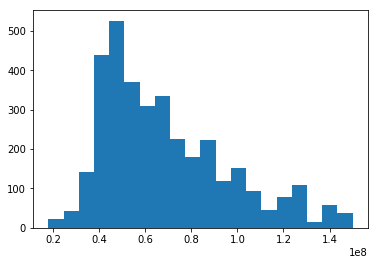

In [104]:
plt.hist(df_kari['価格'].values, bins=20, range=(df_kari['価格'].values.min(), 150000000))